# Initial Setup

## Libraries

In [23]:
import warnings
import sys
warnings.filterwarnings('ignore')

import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

logger = logging.getLogger(__name__)
 
import pprint
import pylab
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

import scipy
from scipy import signal
from scipy.io import wavfile

from tqdm import tqdm_notebook

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler

font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [24]:
print("=== Library Versions ===")
print("SciPy:     ",scipy.__version__)
print("Numpy:     ",np.__version__)

=== Library Versions ===
SciPy:      1.6.0
Numpy:      1.19.5


## Custom Functions

In [97]:
DEBUG = False

HOME_FOLDER = './'

# Data
TEST_DURATION = 10    # seconds
SHUFFLE       = True
 
TRAIN_TEST_SPLIT = 0.85 # Use 85% for training
TRAIN_VAL_SPLIT  = 0.9 # Use another 90% of the remaining data for training and 10% for validation
 
TRAIN_SENSOR_IN  = HOME_FOLDER + 'Dataset/script_100ms_01_cf.csv'
TRAIN_SENSOR_OUT = HOME_FOLDER + 'Dataset/script_100ms_01_vicon.csv'

print("=== File Configuration ===")
print("Sensor Input :", TRAIN_SENSOR_IN)
print("Sensor Output:", TRAIN_SENSOR_OUT)

=== File Configuration ===
Sensor Input : ./Dataset/script_100ms_01_cf.csv
Sensor Output: ./Dataset/script_100ms_01_vicon.csv


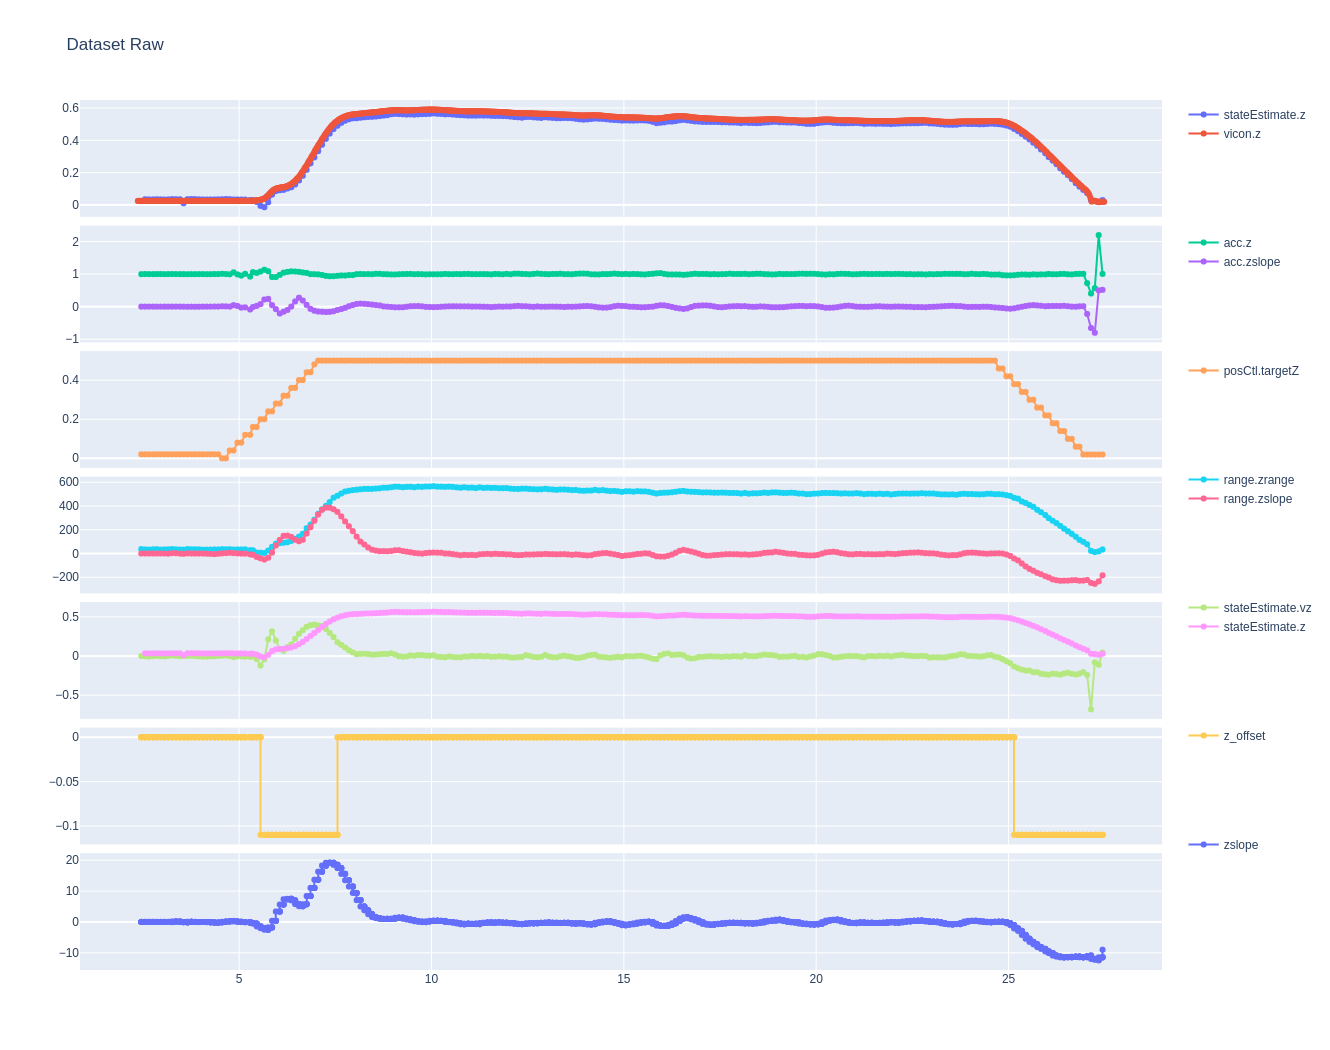

In [98]:
CF_df = pd.read_csv(TRAIN_SENSOR_IN, header=0, names=["Timestamp", "Timestamp_CF", "ID", "Value"]) # New dataformat including timestamp from crazyfly
#CF_df    = pd.read_csv(TRAIN_SENSOR_IN,  header=0, names=["Timestamp", "ID", "Value"])
VICON_df = pd.read_csv(TRAIN_SENSOR_OUT, header=0, names=["Timestamp", "ID", "Value"])

groups = np.unique([x.split(".")[0] for x in np.unique(CF_df["ID"])]) 

fig = make_subplots(rows=len(groups)+1, cols=1, shared_xaxes=True, vertical_spacing=0.01)

drone_z = CF_df.loc[CF_df['ID'] == 'stateEstimate.z'].reset_index(drop=True)
vicon_z = VICON_df.loc[VICON_df['ID'] == 'CF_PHILIP_posz'].reset_index(drop=True)

fig.append_trace(go.Scatter(x=drone_z["Timestamp"]/1000, y= drone_z["Value"], mode="lines+markers", name="stateEstimate.z", legendgroup = 1), row = 1, col = 1)      
fig.append_trace(go.Scatter(x=vicon_z["Timestamp"]/1000, y= vicon_z["Value"], mode="lines+markers", name="vicon.z", legendgroup = 1), row = 1, col = 1)   

# extract the time-of-flight sensor value
for k, group in CF_df.groupby(["ID"]):
    index = groups.tolist().index(k.split(".")[0]) + 2
    group = group.reset_index()
    fig.append_trace(go.Scatter(x=group["Timestamp"]/1000, y= group["Value"], mode="lines+markers", name=k, legendgroup = index), row = index, col = 1)              

fig.update_layout(
    title_text="Dataset Raw", 
    height=(len(groups)+1)*150, 
    width=15*80, 
    legend_tracegroupgap = 90,
)
fig.show()

## Resample datapoint to periodic interval and align them

In [99]:
TIME_INTERVAL = '100L'

drone_z = CF_df.copy()
vicon_z = VICON_df.loc[VICON_df['ID'] == 'CF_PHILIP_posz'].reset_index(drop=True)

vicon_z['Timestamp'] *= 1E6
drone_z['Timestamp'] *= 1E6

vicon_z.index = pd.DatetimeIndex(data=vicon_z['Timestamp'])
time_origin = vicon_z.index.to_pydatetime()[0]
vicon_z_res = vicon_z.drop(columns=['Timestamp', 'ID']).resample(TIME_INTERVAL, origin=time_origin).mean().interpolate()

Dataset_df = pd.DataFrame({'stateEstimate.viconz' : vicon_z_res["Value"] })


# extract the time-of-flight sensor value
for k, group in drone_z.groupby(["ID"]):
    group = group.reset_index()
    group.index = pd.DatetimeIndex(data=group['Timestamp'])
    group = group.drop(columns=['Timestamp']).resample(TIME_INTERVAL, origin= time_origin).mean().interpolate()
    Dataset_df[k] = group["Value"]
    
Dataset_df.dropna(inplace=True)

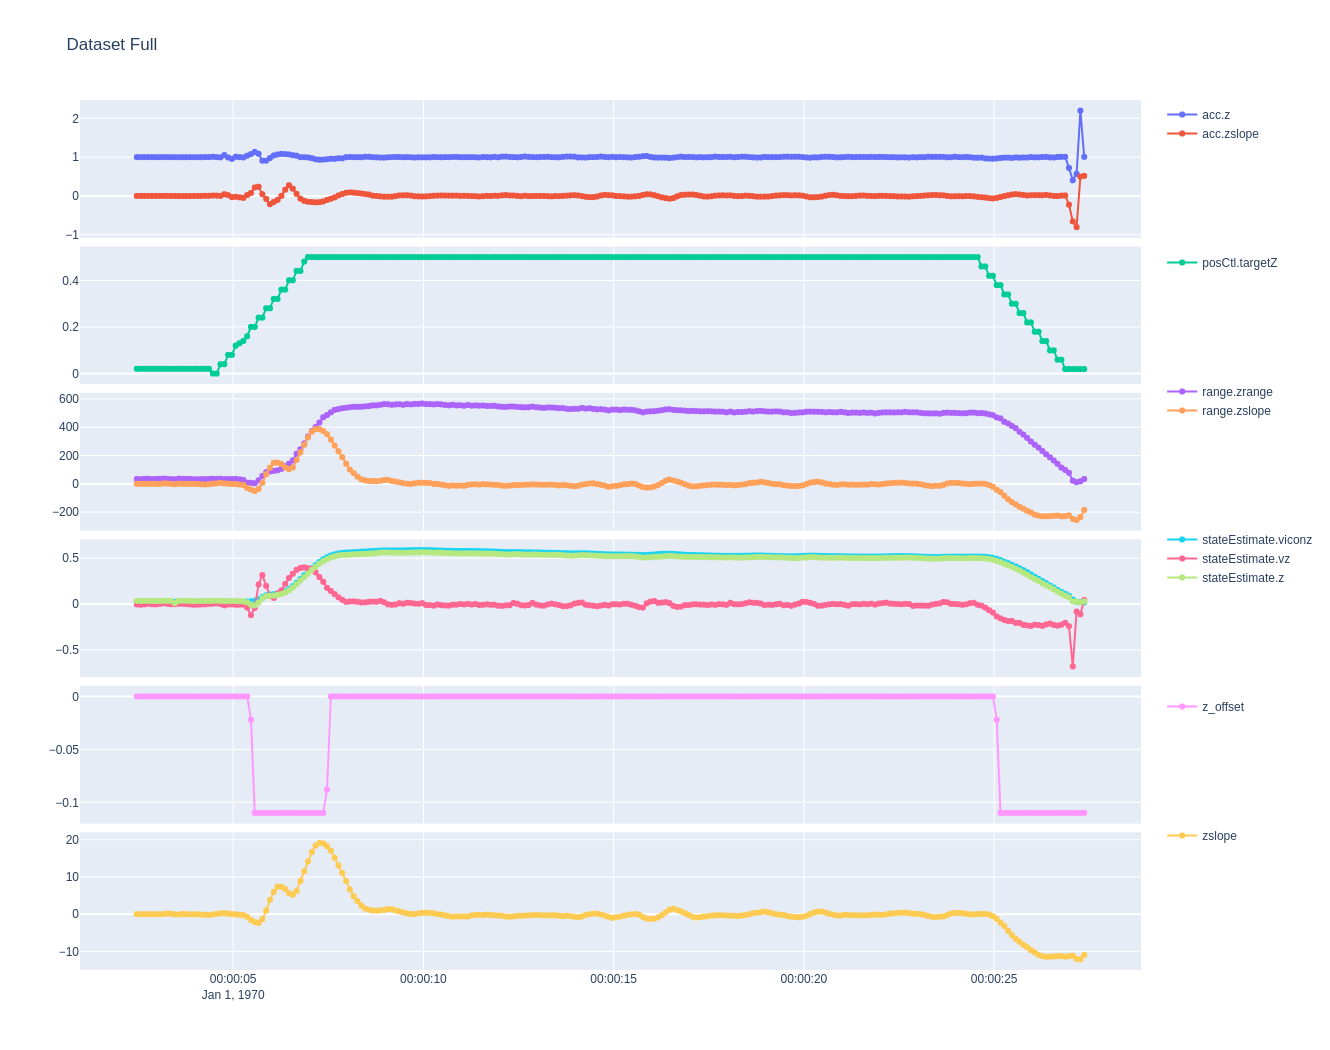

In [100]:
# print(Dataset_df.head())
groups = np.unique([x.split(".")[0] for x in np.unique(Dataset_df.columns)]) 
fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True, vertical_spacing=0.01)

for k in np.sort(Dataset_df.columns):
    index = groups.tolist().index(k.split(".")[0]) + 1
    fig.append_trace(go.Scatter(x=Dataset_df.index, y= Dataset_df[k], mode="lines+markers", name=k, legendgroup = index), row = index, col = 1)  
    
    
drone_z = CF_df.loc[CF_df['ID'] == 'stateEstimate.z'].reset_index(drop=True)
vicon_z = VICON_df.loc[VICON_df['ID'] == 'CF_PHILIP_posz'].reset_index(drop=True)

fig.update_layout(
    title_text="Dataset Full", 
    height=(len(groups)+1)*150, 
    width=15*80, 
    legend_tracegroupgap = 110,
)
fig.show()

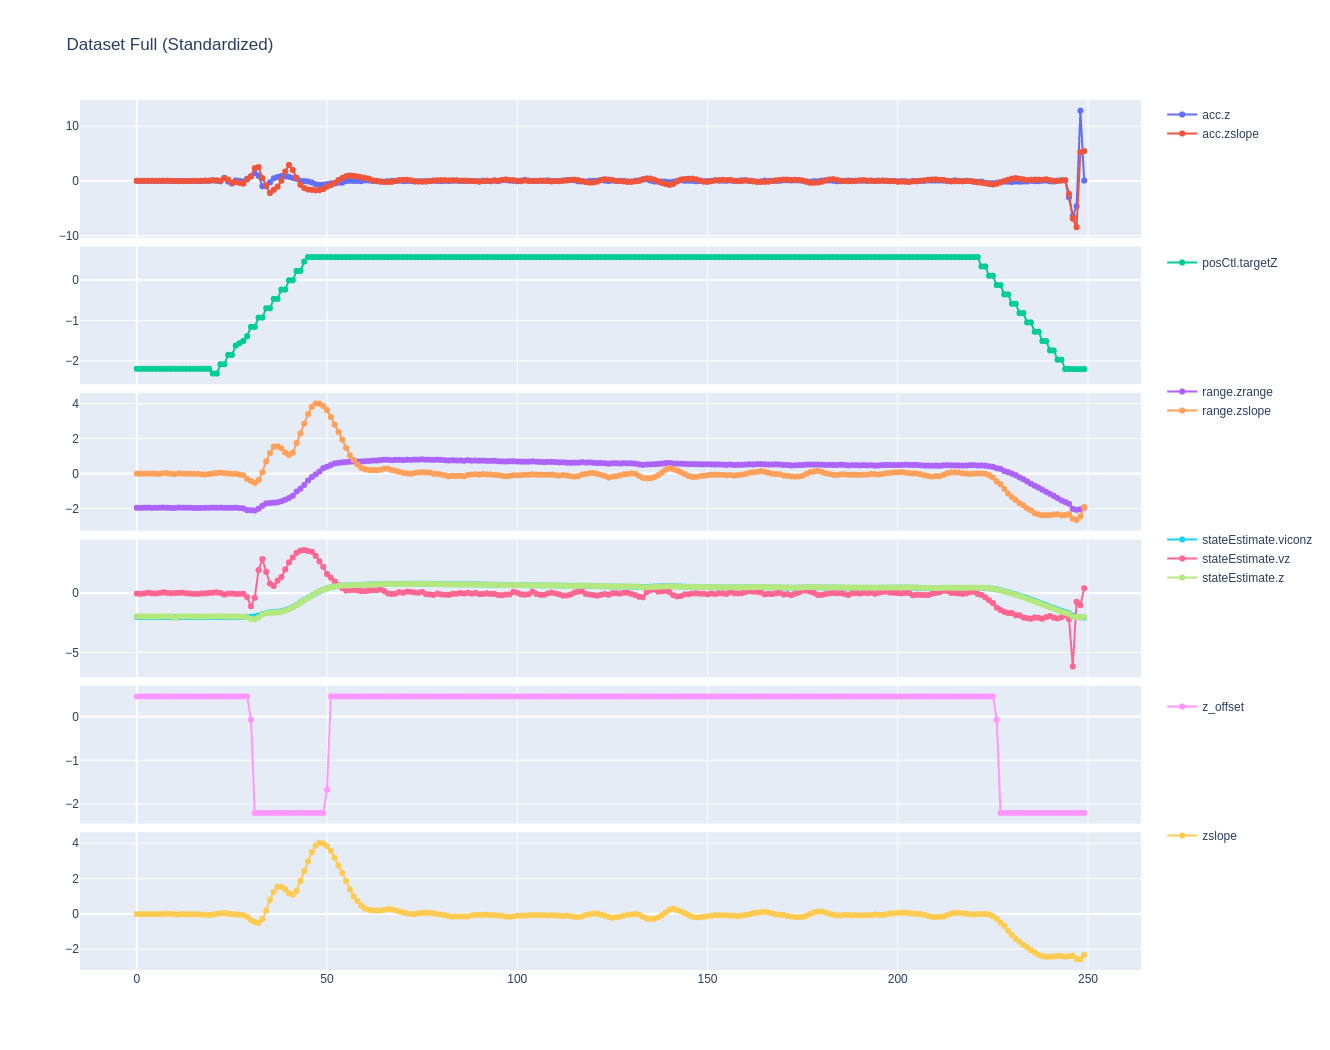

In [101]:
scl = StandardScaler()
data_scl_df = pd.DataFrame(data = scl.fit_transform(Dataset_df), columns=Dataset_df.columns)


groups = np.unique([x.split(".")[0] for x in np.unique(Dataset_df.columns)]) 
fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True, vertical_spacing=0.01)

for k in np.sort(data_scl_df.columns):
    index = groups.tolist().index(k.split(".")[0]) + 1
    fig.append_trace(go.Scatter(x=data_scl_df.index, y= data_scl_df[k], mode="lines+markers", name=k, legendgroup = index), row = index, col = 1)  
    

fig.update_layout(
    title_text="Dataset Full (Standardized)", 
    height=(len(groups)+1)*150, 
    width=15*80, 
    legend_tracegroupgap = 110,
)
fig.show()